# Compare - Shanghai Composite Index

1. PAPER: [Financial Time Series Forecasting with the Deep Learning Ensemble Model](https://www.mdpi.com/2227-7390/11/4/1054) by He K., et al. 2023
2. NOTE (of stock data):
    1. **Raw Data** is mostly non-stationary.
    2. **Returns Data** is stationary and also called differenced.

In [1]:
import os
import sys
# Get the current working directory of the notebook
notebook_dir = os.getcwd()

# Add the parent directory to the system path
sys.path.append(os.path.join(notebook_dir, '../tslearn/'))

from collections import namedtuple
from data_loader import build_stock_uts, build_downloaded_stock_uts
from time_series import TimeSeriesFactory
from data_plotter import InterpolatePlotter
from ts_models_no_retrain import augment_retrain_predictions, AR_Model, MA_Model, ARMA_Model, ARIMA_Model, EvaluationMetric

## Stock Data: Analysis

1. Load Raw Data
2. Plot Raw Data
3. Get Descriptive Statistics (ie: mean, median, range, etc) of Raw Data
4. Check Stationarity of Raw Data
5. Plot Autocorrelation and Partial Autocorrelation of Raw Data
6. Get Returns Data
7. Plot Returns Data
8. Get Descriptive Statistics (ie: mean, median, range, etc) of Returns Data
9. Check Stationarity of Returns Data
10. Plot Autocorrelation and Partial Autocorrelation of Returns Data

## Stock Data: Models

11. Split Returns Data
12. Initialize Models: `AR(p)` and `ARMA(p, q)`
13. Split Raw Data
14. Initialize Model: `ARMA(p, d, q)`

## Stock Data: Evaluation Metrics + Plots

15. Evaluation Metrics `MSE`, `RMSE`
16. Plot Actual Predictions vs Model Predictions

## Follow-up

- Notes on above

## Stock Data: Analysis

### Load Raw Data

In [2]:
# Only grab stocks whose data is available for the entire time period
train_start_date, train_end_date = "2019-05-05", "2024-02-07"
test_start_date, test_end_date = "2024-02-08", "2025-07-04"
Stock = namedtuple("Stock", ["symbol", "name"])
stocks = [
    # ("000001.SS", "Shanghai Composite Index")
    ("UBER", "Uber Technologies Inc")
]
independent_variable = "Close"
frequency = '1d'
stocks = [Stock(*s) for s in stocks]
train_stocks = {s.symbol: build_stock_uts(s.symbol, s.name, independent_variable, start_date=train_start_date, end_date=train_end_date, frequency=frequency) for s in stocks}
test_stocks = {s.symbol: build_stock_uts(s.symbol, s.name, independent_variable, start_date=test_start_date, end_date=test_end_date, frequency=frequency) for s in stocks}

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
values_cols = list(train_stocks.keys())
stock_mvts = TimeSeriesFactory.create_time_series(
    time_col="date",
    time_values=train_stocks[values_cols[0]].data.index,
    values_cols=values_cols,
    values=[stock.get_series() for stock in train_stocks.values()]
)

values_cols = list(test_stocks.keys())
stock_mvts = TimeSeriesFactory.create_time_series(
    time_col="date",
    time_values=test_stocks[values_cols[0]].data.index,
    values_cols=values_cols,
    values=[stock.get_series() for stock in test_stocks.values()]
)

Len [1194]
Len [1194]
Len [351]
Len [351]


In [4]:
# stock_symbol = '000001.SS'
stock_symbol = 'UBER'

train_stock_of_interest = train_stocks[stock_symbol]
test_stock_of_interest = test_stocks[stock_symbol]
type(train_stock_of_interest), train_stock_of_interest, type(test_stock_of_interest), test_stock_of_interest

(tslearn.time_series.UnivariateTimeSeries,
 UnivariateTimeSeries(Close),
 tslearn.time_series.UnivariateTimeSeries,
 UnivariateTimeSeries(Close))

In [5]:
train_stock_df = train_stock_of_interest.get_as_df()
test_stock_df = test_stock_of_interest.get_as_df()
train_stock_df.tail(7)

,Close
Date,
2024-01-29,66.980003
2024-01-30,66.839996
2024-01-31,65.269997
2024-02-01,66.730003
2024-02-02,68.070000
2024-02-05,68.989998
2024-02-06,70.470001


### Plot Raw Data

In [6]:
test_stock_df.head(7)

,Close
Date,
2024-02-08,71.610001
2024-02-09,70.910004
2024-02-12,69.120003
2024-02-13,68.989998
2024-02-14,79.150002
2024-02-15,81.389999
2024-02-16,78.410004


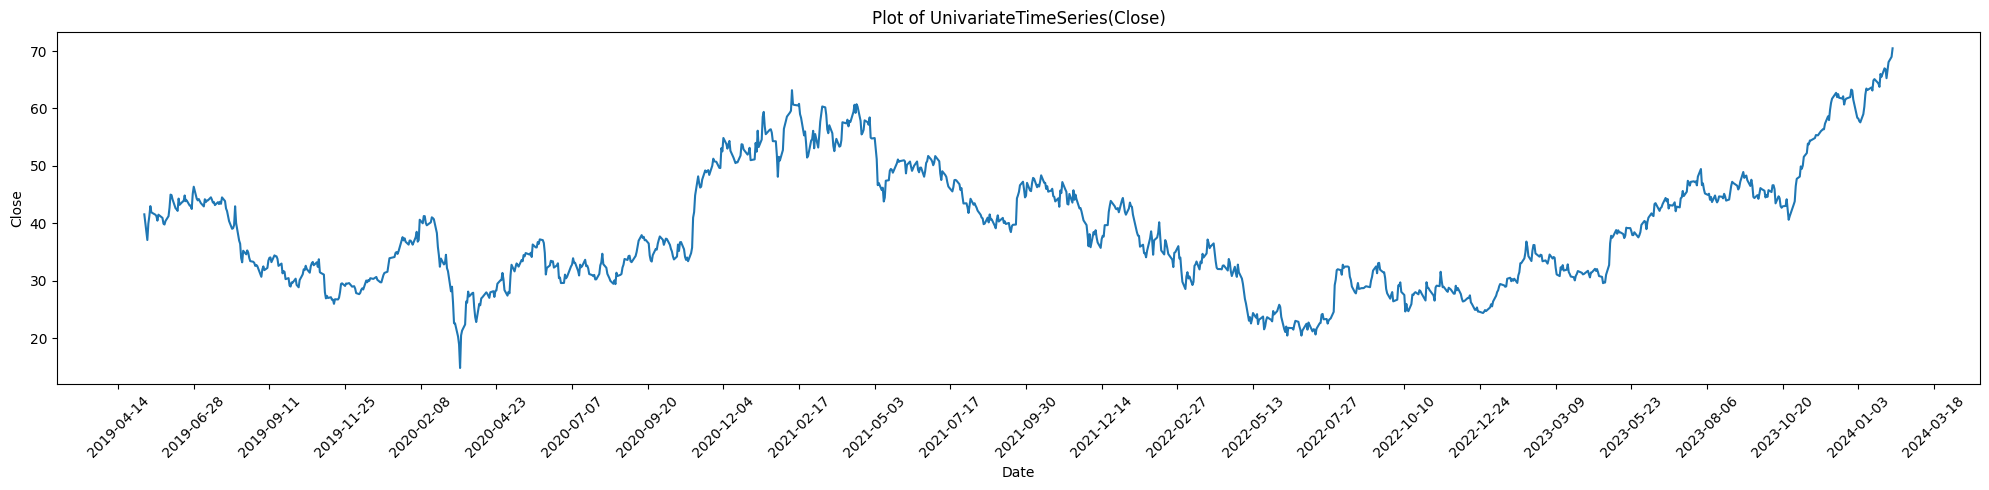

In [9]:
train_stock_of_interest.plot(tick_skip=75)

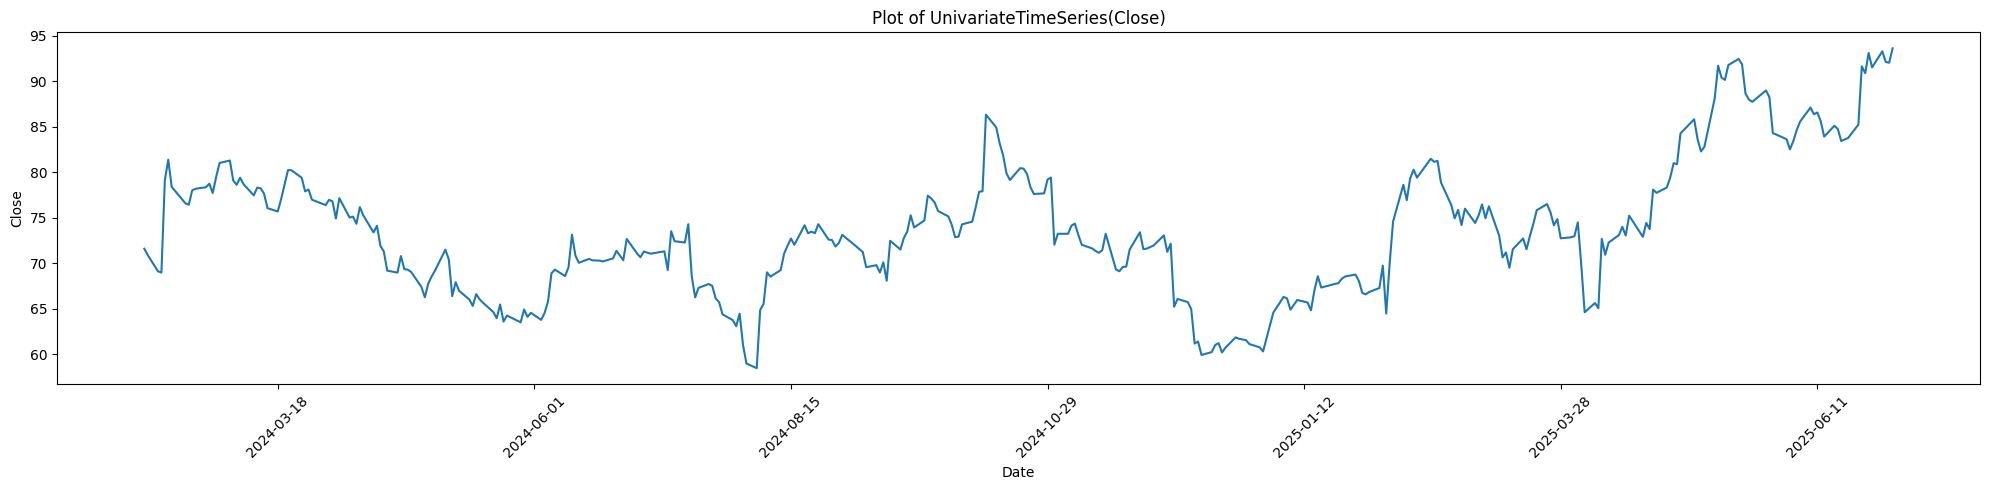

In [10]:
test_stock_of_interest.plot(tick_skip=75)

### Get Descriptive Statistics of Raw Data

In [ ]:
time_type = 'days'
stock_data = True
train_stock_of_interest.get_statistics(time_type, stock_data)

### Check Stationarity of Raw Data

- With financial data, we expect it to be non-stationary (as in there's a change in either or both the mean of the variance between two distant points).

In [ ]:
train_stock_of_interest.stationarity_test(train_stock_df), test_stock_of_interest.stationarity_test(test_stock_df)

### Plot Autocorrelation and Partial Autocorrelation of Raw Data

- Not required for `AR` or `ARMA` models as both models assumes stationary and the TS is non-stationary.
- Get the last X lags
    - X should be end of train and start of test
    - X also should be within the blue confidence region
    - if X = 200, it's NOT 200 of the end of train and start of test. X is 200 of the start train. Needs to be end of train.

In [ ]:
# Use the last N days to predict the next N days, or reworded as 
# Predict the next N days (which is the full length of test set) and use the last N days to do so
train_stock_df[len(test_stock_df):]

In [ ]:
# Since we don't have the compute power to process in a shorter time and we only care for the 
# significant lags (ie: those that are outside of the blue region), choose a max lag based on these two criteriors
# Thus, choose the last 200 days of train
last_N_train_df = train_stock_df.iloc[-500:, :]
last_N_train_df

In [ ]:
test_stock_df

In [ ]:
# train_stock_of_interest.plot_autocorrelation(len(last_N_train_df))
# train_stock_of_interest.plot_partial_autocorrelation(len(last_N_train_df))

- What is the above telling us?
    - Both plots are the same, just showing differently. 
    - Both plots confirm that the TS is non-stationary as in the current value depends on the previous value. We don't want this with traditional TS models like `AR`, `ARMA`.

- What is the above telling us?
    - TS is non-stationary. Although data isn't as dependent (like the ACorr plot), the 1st is dependent upon the 0th. 

### Get Returns Data

- This should provide us with stationary data that we can pass to both `AR` and `ARMA` models.

In [ ]:
# len(stock_of_interest.get_series()), stock_of_interest.get_series()
# stock_returns = stock_of_interest.data_augment_for_returns()
# stock_returns.plot(tick_skip=150)
# stock_returns_df = stock_returns.get_as_df()
# stock_returns.get_statistics()
# stock_returns.stationarity_test(stock_returns_df)
# stock_returns.independence_test(stock_returns_df)
# stock_returns.plot_autocorrelation(50)
# stock_returns.plot_partial_autocorrelation(50)

- What is the above telling us?
    - TS is stationary. The 1st is not dependent upon the 0th. This is what we want for `AR(p)`.
    - Lag exponentially decays at 1, thus use lag 1 for `AR(p)` as they have in the PAPER.

## Stock Data: Models

### Split Differenced Data for `AR(p)`, `MA(q)`, `ARMA(p, q)` Models

- Make 5-day forecasts

In [ ]:
# stock_returns.get_as_df()

In [ ]:
# interpolation_step = 5
# interpolation_step = 120
# N_train = len(train_stock_of_interest.get_series()[lags:])
# interpolation_step = len(test_stock_of_interest.get_series())
# diff_train_length = N_train - interpolation_step

# print(f"Train {diff_train_length}")


In [ ]:
# interpolation_step = 1956
# # interpolation_step = 60
# N = len(stock_returns.get_series())
# diff_train_length = N - interpolation_step
# diff_train_length

In [ ]:
# diff_train_uts, diff_test_uts = train_stock_of_interest.get_slice(1, len(N_train), both_train_test=True)
# diff_train_uts, diff_test_uts

In [ ]:
# diff_train_df = diff_train_uts.get_as_df()
# diff_train_df
# diff_train_values = diff_train_uts.get_series()
# diff_train_values
# diff_test_df = diff_test_uts.get_as_df()
# diff_test_df
# diff_test_values = diff_test_uts.get_series()
# len(diff_test_values)

In [ ]:
N_test_df = len(test_stock_df)
N_test_df

In [ ]:
scatter_type = False
data_prediction_plots = InterpolatePlotter()
data_prediction_plots.plot_ts_training_and_testing_data(train_stock_df, test_stock_df, scatter_type)

#### Initialize Model: `AR(p)`

- Pass `diff_test_values` series instead of `diff_train_df` to drop index of the returned prediction
- Train data: Entire train dataset
- Lags: Of the X last days in train dataset (as in the last day in train + 1 (if not a weekend) and it should be the next day in test), where does significance fall out of range?

In [ ]:
lag_p = 2

In [ ]:
train_stock_values = train_stock_df.values
train_values = augment_retrain_predictions(train_stock_values)
len(train_values), train_values

In [ ]:
len(last_N_train_df)


In [ ]:
no_retrain_name = ' - no retrain'
no_retrain_bool = False

ar_no_retrain_model_class = AR_Model(no_retrain_name, lag_p=len(last_N_train_df))
ar_no_retrain_model_class.train(train_values)
ar_no_retrain_model_class.summary()

In [ ]:
test_stock_values = test_stock_df.values
test_values = augment_retrain_predictions(test_stock_values)
len(test_values), test_values

In [ ]:
# retrain false
ar_predictions = ar_no_retrain_model_class.make_predictions(train_values, test_values)
ar_predictions
all_predictions_df = ar_no_retrain_model_class.model_predictions_to_df(test_stock_df, ar_predictions)
all_predictions_df

In [ ]:
ar_model_pred_name = f"{ar_no_retrain_model_class.__name__()}{no_retrain_name}"
ar_predictions_df = all_predictions_df.loc[:, ar_model_pred_name]
ar_predictions_df

In [ ]:
data_prediction_plots.plot_ts_training_and_testing_data(train_stock_df, test_stock_df, scatter_type, ar_predictions_df)

In [ ]:
EvaluationMetric.eval_mse(test_stock_df, ar_predictions_df, per_element=False)
EvaluationMetric.eval_rmse(test_stock_df, ar_predictions_df, per_element=False)

#### Initialize Model: `MA(q)`

In [ ]:
no_retrain_name

In [ ]:
error_q = 1 # MA
ma_model_class = MA_Model(no_retrain_name, error_q=error_q)
ma_model_class.train(diff_train_df.values)
ma_model_class.summary()

In [ ]:
ma_predictions_no_retrain = ma_model_class.make_predictions(diff_train_df, diff_test_df)
all_predictions_df = ma_model_class.model_predictions_to_df(diff_test_df, ma_predictions_no_retrain)
all_predictions_df

In [ ]:
ma_predictions_df = all_predictions_df.iloc[:, 2]
ma_predictions_df

In [ ]:
EvaluationMetric.eval_mse(all_predictions_df.iloc[:, 0], all_predictions_df.iloc[:, 2], per_element=False)
EvaluationMetric.eval_rmse(all_predictions_df.iloc[:, 0], all_predictions_df.iloc[:, 2], per_element=False)

data_prediction_plots.plot_ts_training_and_testing_data(diff_train_df, diff_test_df, scatter_type, ma_predictions_df)

#### Initialize Model: `ARMA(p, q)`

In [ ]:
arma_model_class = ARMA_Model(no_retrain_name, lag_p, error_q)
arma_model_class.train(diff_train_df.values)
arma_model_class.summary()

NOTE: Should Dep. Variable be t as t depends on t - 1?

In [ ]:
# retrain false
arma_predictions_no_retrain = arma_model_class.make_predictions(diff_train_df, diff_test_df)
all_predictions_df = arma_model_class.model_predictions_to_df(diff_test_df, arma_predictions_no_retrain)
all_predictions_df

In [ ]:
arma_predictions_df = all_predictions_df.iloc[:, 3]
arma_predictions_df

In [ ]:
EvaluationMetric.eval_mse(all_predictions_df.iloc[:, 0], all_predictions_df.iloc[:, 3], per_element=False)
EvaluationMetric.eval_rmse(all_predictions_df.iloc[:, 0], all_predictions_df.iloc[:, 3], per_element=False)

data_prediction_plots.plot_ts_training_and_testing_data(diff_train_df, diff_test_df, scatter_type, arma_predictions_df)

### Split Raw Data for `ARIMA(p, d, q)` Model

- Make 5-day forecasts

In [ ]:
# interpolation_step = 5
# interpolation_step = 60
# N = len(stock_of_interest.get_series())
# train_length = N - interpolation_step
# train_length

N = len(stock_of_interest.get_series())
interpolation_step = N - int(N * .8)
train_length = N - interpolation_step

print(f"IS: {interpolation_step}\nTrain {diff_train_length}")

In [ ]:
train_uts, test_uts = stock_of_interest.get_slice(start=1, end=train_length, both_train_test=True)
train_uts, test_uts

In [ ]:
train_df = train_uts.get_as_df()
test_df = test_uts.get_as_df()
train_df.plot(), test_df.plot()

In [ ]:
train_values = train_uts.get_series()
test_values = test_uts.get_series()
len(train_values), len(test_values)

In [ ]:
arima_plotter = InterpolatePlotter()
arima_plotter.plot_ts_training_and_testing_data(train_df, test_df, True)
arima_plotter.plot_ts_training_and_testing_data(train_df, test_df, False)

#### Initialize Models: `ARIMA(p, d, q)`

In [ ]:
diff_d = 1

arima_model_class = ARIMA_Model(no_retrain_name, lag_p, error_q, diff_d)
trained_arima_model = arima_model_class.train(train_values)
# trained_arima_model.summary()

In [ ]:
arima_predictions = arima_model_class.make_predictions(diff_train_values, diff_test_values)
all_raw_predictions_df = arima_model_class.model_predictions_to_df(test_df, arima_predictions)
all_raw_predictions_df

In [ ]:
arima_predictions_df = all_raw_predictions_df.iloc[:, 1]
len(arima_predictions_df), arima_predictions_df.head(3)

In [ ]:
EvaluationMetric.eval_mse(all_predictions_df.iloc[:, 0], all_predictions_df.iloc[:, 1], per_element=False)
EvaluationMetric.eval_rmse(all_predictions_df.iloc[:, 0], all_predictions_df.iloc[:, 1], per_element=False)

arima_plotter.plot_ts_training_and_testing_data(train_df, test_df, scatter_type=False, predictions_df=arima_predictions_df)

## Stock Data: Evaluation Metrics + Plots

### Evaluation Metrics: MSE, RMSE

### Plots Actual Predictions vs Model Predictions
- Need to finish plots

## Follow-up